### Ensemble Classfiers

In [1]:
import torch as torch
import random
from sklearn.metrics import classification_report
from random import randint

#### Get the dataset

In [2]:
import pandas as pd
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import ConcatDataset
import numpy as np
# Extra info for logging
extra = 'change to freeze all layers + dropout 0.5 + unfreeze batchnorm + cropped images + track both best val_loss and val_acc + add original image + test image not cropped + add augmented_more dataset + no crop augmented data'

# Load the metadata
metadata = pd.read_csv('meta_data.csv')
metadata['augmented_images_more'] = metadata['augmented_image_name'].str.replace('augmented_images','augmented_images_more')
metadata['augmented_image_nocrop_name'] = metadata['augmented_image_name'].str.replace('augmented_images','augmented_images_nocrop')

# Create a dictionary mapping from image file name to is_training_image

# Only add training images for augmented
temp = metadata[metadata.is_training_image == 1]

is_training_image = dict(zip(temp.augmented_image_name, temp.is_training_image))   # original augmentation
is_training_image.update(zip(temp.augmented_images_more, temp.is_training_image))  # more augmentation
is_training_image.update(zip(temp.augmented_image_nocrop_name, temp.is_training_image)) # augmented but no crop to bbox

# Add original data
# Test will be from original images (not cropped, only resize to 224,224)
is_training_image.update(zip(metadata.image_name, metadata.is_training_image))

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
dataset_augmented = ImageFolder("../augmented_images", transform=transform)
dataset_images = ImageFolder("../CUB_200_2011/images", transform=transform)
dataset_augmented_more = ImageFolder("../augmented_images_more", transform=transform)
dataset_augmented_nocrop = ImageFolder("../augmented_images_nocrop", transform=transform)


# Combine datasets
all_classes = sorted(set(dataset_images.classes + dataset_augmented.classes + dataset_augmented_more.classes + dataset_augmented_nocrop.classes))
combined_dataset = ConcatDataset([dataset_images, dataset_augmented, dataset_augmented_more, dataset_augmented_nocrop])
combined_dataset.classes = all_classes

print("Loading test indices...")
test_indices = np.load('test_indices.npy')

# Create subset datasets
test_dataset = Subset(combined_dataset, test_indices)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Test set size: ", len(test_dataset))

Loading test indices...
Test set size:  4634


#### Load the required models

In [3]:
import torch
from torch import nn
from torchvision.models import efficientnet_b0
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()

    def training_step(self, batch):
        raise NotImplementedError

    def validation_step(self, batch):
        raise NotImplementedError

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss']))

class EfficientNetModel(BaseModel):
    def __init__(self, num_classes):
        super().__init__()
        self.network = efficientnet_b0(pretrained=True)

        # Add custom layers
        self.network.classifier = nn.Sequential(
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )


    def forward(self, xb):
        return self.network(xb)

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def freeze(self):
        # Freeze all the parameters of the model
        for param in self.network.parameters():
            param.requires_grad = False

        # Unfreeze the last layers
        for param in list(self.network.parameters())[0:-4]:
            param.requires_grad = True

    def unfreeze(self):
        # Unfreeze all parameters of the model
        for param in self.network.parameters():
            param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
num_classes = len(combined_dataset.classes)
# model1 = torch.load(MODEL1_PATH, map_location=device)
# model1.eval()

Device:  cuda


In [4]:
from torchvision.models import mobilenet_v2
import torch.nn.functional as F

class MobileNetModel(BaseModel):
    def __init__(self, num_classes):
        super().__init__()
        self.network = mobilenet_v2(pretrained=True)

        # No freezing
        # for param in self.network.parameters():
        #     param.requires_grad = True

        # Freeze all the parameters of the model
        for param in self.network.parameters():
            param.requires_grad = False

        # # Unfreeze the last five layers
        # for param in list(self.network.parameters())[-5:]:
        #     param.requires_grad = True

        # Unfreeze Batch Normalization
        for module in self.network.modules():
            if isinstance(module, nn.BatchNorm2d):
                for param in module.parameters():
                    param.requires_grad = True

        # Unfreeze last layer
        for param in self.network.features[-1].parameters():
            param.requires_grad = True
                    
        # Replace the classifier with a custom one
        num_ftrs = self.network.classifier[1].in_features
        self.network.classifier = nn.Sequential(
            nn.Dropout(0.5), 
		    nn.Linear(num_ftrs, num_classes)
            )
        # self.network.classifier[1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, xb):
        return self.network(xb)

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

In [5]:
from torchvision.models import googlenet
import torch.nn.functional as F

class GoogLeNetModel(BaseModel):
    def __init__(self, num_classes):
        super().__init__()
        self.network = googlenet(pretrained=True)

        # Freeze all the parameters of the model
        for param in self.network.parameters():
            param.requires_grad = False

        # Unfreeze the last five layers
        for param in list(self.network.parameters())[-4:]:
            param.requires_grad = True

        # Replace the classifier with a custom one
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
        
    def unfreeze_all(self):
        for param in self.network.parameters():
            param.requires_grad = True
    
    def freeze_all_except_custom(self):
        # Freeze all the parameters of the model
        for param in self.network.parameters():
            param.requires_grad = False

        # Unfreeze the last 4 layer
        list(self.network.parameters())[-4].requires_grad = True

    def forward(self, xb):
        return self.network(xb)

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

In [6]:
MODEL1_PATH = './efficient_net_best/efficientnet_b0.pth'
MODEL2_PATH = './google_net/best model with normalising/googlenet_best_3.pth'
MODEL3_PATH = './mobile_net/mobilenet_best.pth'

In [7]:
# model1 = TheModelClass(*args, **kwargs)
# model1.load_state_dict(torch.load(MODEL1_PATH))
model1 = torch.load(MODEL1_PATH, map_location=device)
model1.eval()
model2 = torch.load(MODEL2_PATH, map_location=device)
model2.eval()
# model2 = MobileNetModel(num_classes)
# model2.load_state_dict(torch.load(MODEL2_PATH, map_location=device))
# model2 = model2.to(device)
# model2.eval()
model3 = MobileNetModel(num_classes)
model3.load_state_dict(torch.load(MODEL3_PATH, map_location=device))
model3 = model3.to(device)
model3.eval()

c:\Users\wamik\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\wamik\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetModel(
  (network): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size

In [8]:
model1_preds = [] # data predictions from model1
model2_preds = [] # data predictions from model2
model3_preds = [] # data predictions from model3
labels = []
with torch.no_grad():  # No need to track gradients
    for i in range(len(test_dataset)):
        inputs, l = test_dataset[i]
        inputs = inputs.to(device).unsqueeze(0)  # Convert inputs to tensor and send to device
        l = torch.tensor([l]).to(device)  # Convert label to tensor and send to device
        outputs = model1(inputs).cpu()
        model1_preds.extend(outputs)
        labels.extend(l.tolist())

with torch.no_grad():  # No need to track gradients
    for i in range(len(test_dataset)):
        inputs, l = test_dataset[i]
        inputs = inputs.to(device).unsqueeze(0)  # Convert inputs to tensor and send to device
        outputs = model2(inputs).cpu()
        model2_preds.extend(outputs)

with torch.no_grad():  # No need to track gradients
    for i in range(len(test_dataset)):
        inputs, l = test_dataset[i]
        inputs = inputs.to(device).unsqueeze(0)  # Convert inputs to tensor and send to device
        outputs = model3(inputs).cpu()
        model3_preds.extend(outputs)

# Expected outputs
num_of_classes = num_classes
expected_output_labels = labels # Expected output labels, assuming that all models are working with the same images
data_outputs = np.zeros((len(expected_output_labels), num_of_classes))
data_outputs[np.arange(len(expected_output_labels)), expected_output_labels] = 1
print("Expected output labels: ", expected_output_labels)
print("Data outputs length: ", data_outputs.shape)

Expected output labels:  [145, 15, 152, 199, 82, 55, 160, 97, 74, 103, 50, 124, 25, 151, 194, 194, 2, 65, 135, 79, 168, 59, 104, 181, 160, 71, 147, 125, 191, 163, 27, 154, 152, 170, 120, 89, 20, 163, 181, 108, 89, 74, 30, 32, 53, 114, 125, 196, 87, 9, 49, 40, 22, 114, 1, 95, 53, 50, 175, 160, 39, 27, 145, 80, 25, 126, 172, 71, 129, 33, 3, 81, 73, 31, 130, 115, 166, 136, 66, 139, 153, 12, 173, 102, 102, 13, 137, 13, 31, 149, 150, 73, 49, 147, 27, 11, 8, 65, 83, 106, 20, 136, 53, 119, 102, 25, 45, 81, 97, 81, 84, 33, 16, 135, 145, 132, 69, 44, 183, 55, 142, 49, 109, 143, 192, 80, 184, 86, 55, 180, 165, 188, 143, 110, 177, 78, 103, 61, 55, 41, 176, 151, 135, 46, 2, 69, 47, 113, 147, 52, 126, 31, 62, 55, 105, 9, 148, 100, 48, 81, 152, 112, 37, 82, 157, 74, 119, 35, 123, 182, 90, 52, 15, 59, 192, 190, 177, 99, 124, 38, 177, 61, 34, 182, 151, 24, 113, 19, 87, 16, 76, 106, 52, 58, 28, 72, 38, 73, 198, 164, 93, 22, 123, 39, 71, 149, 25, 158, 160, 156, 59, 183, 106, 171, 66, 2, 119, 147, 142, 1

In [9]:
# Check if `model2_preds` contains arrays of different lengths
lengths = [len(pred) for pred in model1_preds]
if len(set(lengths)) > 1:
    print("model2_preds contains arrays of different lengths: ", lengths)
else:
    print("All arrays in model2_preds have the same length: ", lengths)

# Check if `model2_preds` contains arrays of different lengths
lengths = [len(pred) for pred in model2_preds]
if len(set(lengths)) > 1:
    print("model2_preds contains arrays of different lengths: ", lengths)
else:
    print("All arrays in model2_preds have the same length: ", lengths)

# Check if `model3_preds` contains arrays of different lengths
lengths = [len(pred) for pred in model3_preds]
if len(set(lengths)) > 1:
    print("model3_preds contains arrays of different lengths: ", lengths)
else:
    print("All arrays in model3_preds have the same length: ", lengths)

print("Model 1 prediction length: ", len(model1_preds))
print("Model 2 prediction length: ", len(model2_preds))
print("Model 3 prediction length: ", len(model3_preds))

All arrays in model2_preds have the same length:  [200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,

In [10]:
from sklearn.metrics import accuracy_score

def test_model(preds, actual):
    '''
    Tests a model by calculating and printing its accuracy.
    '''
    # Convert probabilities to class labels
    preds_class = []
    for pred in preds:
        preds_class.append(np.argmax(pred))

    # Calculate the accuracy of the model
    accuracy = accuracy_score(actual, preds_class)

    # Print the accuracy of the model
    print("Accuracy: {:.2f}%".format(accuracy * 100))

print("Calculating accuracy for efficient net...")
test_model(model1_preds, expected_output_labels)
print("Calculating accuracy for google net...")
test_model(model2_preds, expected_output_labels)
print("Calculating accuracy for mobile net...")
test_model(model3_preds, expected_output_labels)

Calculating accuracy for efficient net...


Accuracy: 90.83%
Calculating accuracy for google net...
Accuracy: 86.71%
Calculating accuracy for mobile net...
Accuracy: 87.07%


#### Helper Functions

In [11]:
import torch.nn.functional as F
def weighted_probability(num_of_classfiers, num_of_classes, networks_outputs, curr_weight_combi):
    '''
    Given an array contain the predictions from each classifier and the weights to be assigned to each classifier, 
    this function computes the final weighted probability.
    '''
    result = [0 for i in range(0, num_of_classes)]
    sum_of_weights = 0

    for i in range(0, num_of_classfiers):
        curr_network_output = networks_outputs[i]
        curr_weight = curr_weight_combi[i]
        sum_of_weights += curr_weight

        for j in range(0, num_of_classes):
            result[j] += curr_network_output[j] * curr_weight
    
    for k in range(0, num_of_classes):
        result[k] = result[k] / sum_of_weights

    return result


def fitness(y_pred, y_true): 
    '''
    Calculates the negative log loss.
    '''
    y_pred_tensor = torch.from_numpy(y_pred).float()
    y_true_tensor = torch.from_numpy(y_true).float()
    return F.cross_entropy(y_pred_tensor, y_true_tensor)


def mutate(weight_combi):
    '''
    Randomly changes a given float number (up to 2%). 
    '''
    for i in range(0, len(weight_combi)):
        weight_combi[i] = weight_combi[i] * random.uniform(0.99, 1.01)
    
    return weight_combi


def cross_over(num_of_classifiers, parent_1, parent_2):
    '''
    Given 2 different possible weight combination, this function produces a final weight combination by randomly extracting 
    weight elements from either parent combinations.
    '''
    cut = random.randint(0, num_of_classifiers - 1)
    new_weight_combi = parent_1[:cut] 
    new_weight_combi.extend(parent_2[cut:])

    return new_weight_combi


def generate_possible_weight_combis(num_of_classifiers, num_of_combis, weight_limit):
    '''
    Produces combinations of weights that can be assigned to each of the classifiers. 
    '''
    print("Generating possible weight combinations...")
    possible_weight_combis = []

    while (num_of_combis > 0):
        curr_weight_combi = []

        while (len(curr_weight_combi) < num_of_classifiers):
            curr_weight = random.uniform(0, weight_limit)
            curr_weight_combi.append(curr_weight)
        
        possible_weight_combis.append(curr_weight_combi)
        num_of_combis -= 1
    
    return possible_weight_combis


#### Genetic Algorithm to find the optimal weights for each classifier

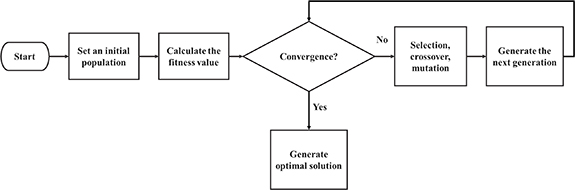

Source: https://iopscience.iop.org/article/10.1088/2632-2153/ad10cf#mlstad10cfs2

In [ ]:
# Defining essential variables
num_of_classifiers = 3
num_of_required_weight_combis = 20
num_of_classes = num_classes
weight_limit = 100
possible_weight_combis = generate_possible_weight_combis(num_of_classifiers, num_of_required_weight_combis, weight_limit)
max_num_of_iters = 10

while (max_num_of_iters > 0):
    # Step 1: Randomly chossing 50% of the dataset to calculate the fitness scores for
    chosen_y_true = []
    chosen_y_model1_pred = []
    chosen_y_model2_pred = []
    chosen_y_model3_pred = []

    required_num_of_samples = len(data_outputs) // 2 # Rounding down

    random_indices = []
    while required_num_of_samples > 0:
        curr_index = randint(0, len(data_outputs) - 1)

        if (curr_index not in random_indices):
            chosen_y_true.append(data_outputs[curr_index])
            chosen_y_model1_pred.append(model1_preds[curr_index])
            chosen_y_model2_pred.append(model2_preds[curr_index])
            chosen_y_model3_pred.append(model3_preds[curr_index])

            random_indices.append(curr_index)
            required_num_of_samples -= 1

    # Step 2: Calculate the average fitness scores for each of the possible weight combinations
    fitness_and_weights = []
    print("Calculating fitness scores for each weight combination...")

    for weights in possible_weight_combis:
        accumulated_fitness_score = 0
        num_of_samples = len(chosen_y_true)

        for i in range(0, num_of_samples):
            network_outputs = [chosen_y_model1_pred[i], chosen_y_model2_pred[i], chosen_y_model3_pred[i]]
            y_pred = np.array(weighted_probability(num_of_classifiers, num_of_classes, network_outputs, weights))
            y_true = np.array(chosen_y_true[i])
            fitness_score = fitness(y_pred, y_true)
            accumulated_fitness_score += fitness_score
        
        avg_fitness_score = accumulated_fitness_score / num_of_samples
        fitness_and_weights.append((avg_fitness_score, weights))

    # Step 3: Rank the weight combis from best to worse
    print("Ranking the weight combinations from best to worst...")
    fitness_and_weights.sort() # The combis with the lowest log loss is at the start

    # Step 4: Selecting parents
    parents = []
    curr_index = 0

    print("Selecting parents...")

    # Selecting top 20% of the weight combis
    top_20_percent = int(len(fitness_and_weights) // 5) # Rounding down
    while (top_20_percent > 0):
        parents.append(fitness_and_weights[curr_index][1])
        top_20_percent -= 1
        curr_index += 1

    # Randomly choosing another 10% of the weight combinations
    another_10_percent = int(len(fitness_and_weights) // 10)  # Rounding down
    while(another_10_percent > 0):
        random_score_and_parent = random.choice(fitness_and_weights[curr_index:])
        parents.append(random_score_and_parent[1])
        fitness_and_weights.remove(random_score_and_parent)

        another_10_percent -= 1

    # Step 5: Randomly mutate 5% of the selected parents
    num_of_parents_to_mutate = max(1, int(len(parents) // 20))  # Rounding down
    index_of_parents_to_mutate = [random.randint(0, len(parents) - 1) for i in range(0, num_of_parents_to_mutate)]

    for index in index_of_parents_to_mutate:
        parents[index] = mutate(parents[index])

    # Step 6: Randomly cross over parents to produce new set of weight combinations
    print("Crossing over parents to produce new set of weight combinations...")
    new_weight_combis = []
    index_of_crossed_parents = []
    num_of_curr_weights = 0

    while (num_of_curr_weights < num_of_required_weight_combis):
        chosen_parents = (random.randint(0, len(parents) - 1), random.randint(0, len(parents) - 1))
        parent_1 = parents[chosen_parents[0]]
        parent_2 = parents[chosen_parents[1]]

        if (parent_1 != parent_2 and chosen_parents not in index_of_crossed_parents):
            new_weight_combi = cross_over(num_of_classifiers, parent_1, parent_2)
            new_weight_combis.append(new_weight_combi)
            num_of_curr_weights += 1

    possible_weight_combis = new_weight_combis
    print(possible_weight_combis) # For testing

    max_num_of_iters -= 1

# Step 7: Select the best weights combination
print("Selecting the best weight combination...")
final_fitness_and_weights = []

for weights in possible_weight_combis:
    accumulated_fitness_score = 0
    num_of_samples = 0

    for i in range(0, len(chosen_y_true)):
            network_outputs = [chosen_y_model1_pred[i], chosen_y_model2_pred[i], chosen_y_model3_pred[i]]
            y_pred = np.array(weighted_probability(num_of_classifiers, num_of_classes, network_outputs, weights))
            y_true = np.array(chosen_y_true[i])
            fitness_score = fitness(y_pred, y_true)
            accumulated_fitness_score += fitness_score

            num_of_samples += 1
    
    avg_fitness_score = accumulated_fitness_score / num_of_samples
    final_fitness_and_weights.append((avg_fitness_score, weights))

final_fitness_and_weights.sort() # The combis with the lowest log loss is at the start
best_weights = final_fitness_and_weights[0][1]
print("The best weight combination is: " + str(best_weights))
print("The fitness score of this combination is: " + str(final_fitness_and_weights[0][0]))

#### Computing the performance of the ensemble model

##### Normalised data all models
RUN 1:
The best weight combination is: [54.97257028459115, 57.00192805450075, 64.56261854388869]
The fitness score of this combination is: tensor(0.3709)
Accuracy Score:  0.9270608545533017

RUN 2:
The best weight combination is: [79.82606167753748, 79.25197094802402, 99.6149947970938]
The fitness score of this combination is: tensor(0.3148)
Accuracy Score:  0.9268450582649979

RUN 3:
The best weight combination is: [80.47025910555283, 65.31509263054947, 93.21472012285388]
The fitness score of this combination is: tensor(0.3526)
Accuracy Score:  0.9281398359948209

RUN 4:
The best weight combination is: [73.3618126614145, 56.80143242583199, 82.68929558492971]
The fitness score of this combination is: tensor(0.3786)
Accuracy Score:  0.9281398359948209

RUN 5:
The best weight combination is: [68.31502618783361, 57.61347555391219, 94.09253824002447]
The fitness score of this combination is: tensor(0.3426)
Accuracy Score:  0.9277082434182132

RUN 6:
The best weight combination is: [36.21591452515949, 48.150340360530755, 48.4088462727387]
The fitness score of this combination is: tensor(0.3561)
Accuracy Score:  0.9261976694000863

RUN 7:
The best weight combination is: [55.32625005506765, 46.217221975546934, 81.16466146189893]
The fitness score of this combination is: tensor(0.3267)
Accuracy Score:  0.9277082434182132

RUN 8:
The best weight combination is: [53.44204784920299, 67.71609174208659, 87.2970134669124]
The fitness score of this combination is: tensor(0.3531)
Accuracy Score:  0.9264134656883901

RUN 9:
The best weight combination is: [43.085985800621444, 38.25721356662487, 54.639372348040524]
The fitness score of this combination is: tensor(0.3458)
Accuracy Score:  0.927924039706517

RUN 10:
The best weight combination is: [65.4771441416988, 51.47812468361519, 65.55558425398662]
The fitness score of this combination is: tensor(0.3918)
Accuracy Score:  0.9285714285714286

RUN 11:
The best weight combination is: [65.50576165440533, 46.890312875150244, 80.84055259279353]
The fitness score of this combination is: tensor(0.3092)
Accuracy Score:  0.9285714285714286

RUN 12:
The best weight combination is: [40.856546190749725, 42.34339836176867, 58.45603423181724]
The fitness score of this combination is: tensor(0.3256)
Accuracy Score:  0.9274924471299094

RUN 13:
The best weight combination is: [41.49589372350115, 38.94196400967405, 45.57734927194985]
The fitness score of this combination is: tensor(0.3170)
Accuracy Score:  0.9272766508416055

RUN 14:
The best weight combination is: [64.16348562632672, 67.21844934067629, 81.13469702927193]
The fitness score of this combination is: tensor(0.3476)
Accuracy Score:  0.9274924471299094

RUN 15:
The best weight combination is: [91.82903498988969, 82.8197333823247, 97.59833132015963]
The fitness score of this combination is: tensor(0.3063)
Accuracy Score:  0.9281398359948209

In [12]:
best_weights = [65.50576165440533, 46.890312875150244, 80.84055259279353]

In [13]:
from sklearn.metrics import accuracy_score
num_of_classifiers = 3
# Get final prediction of data based on the best weight combination
final_predictions = [weighted_probability(num_of_classifiers, num_of_classes, [model1_preds[i], model2_preds[i], model3_preds[i]], best_weights) for i in range(0, len(model1_preds))]
final_predictions = np.array(final_predictions)

# Get the final classification report
final_predictions = np.argmax(final_predictions, axis=1)
expected_output_labels = np.argmax(data_outputs, axis=1)
print("Accuracy Score: ", accuracy_score(expected_output_labels, final_predictions))
print(classification_report(expected_output_labels, final_predictions))


Accuracy Score:  0.9283556322831247
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        22
           1       1.00      1.00      1.00        25
           2       1.00      0.95      0.97        20
           3       0.88      1.00      0.93        21
           4       0.92      1.00      0.96        11
           5       0.90      1.00      0.95         9
           6       1.00      1.00      1.00        18
           7       0.79      0.92      0.85        12
           8       0.78      0.91      0.84        23
           9       0.96      1.00      0.98        23
          10       0.88      0.95      0.91        22
          11       1.00      1.00      1.00        17
          12       1.00      1.00      1.00        26
          13       1.00      0.91      0.95        22
          14       0.96      1.00      0.98        23
          15       1.00      0.96      0.98        24
          16       1.00      1.00      1.00  

Saving confusion matrix...


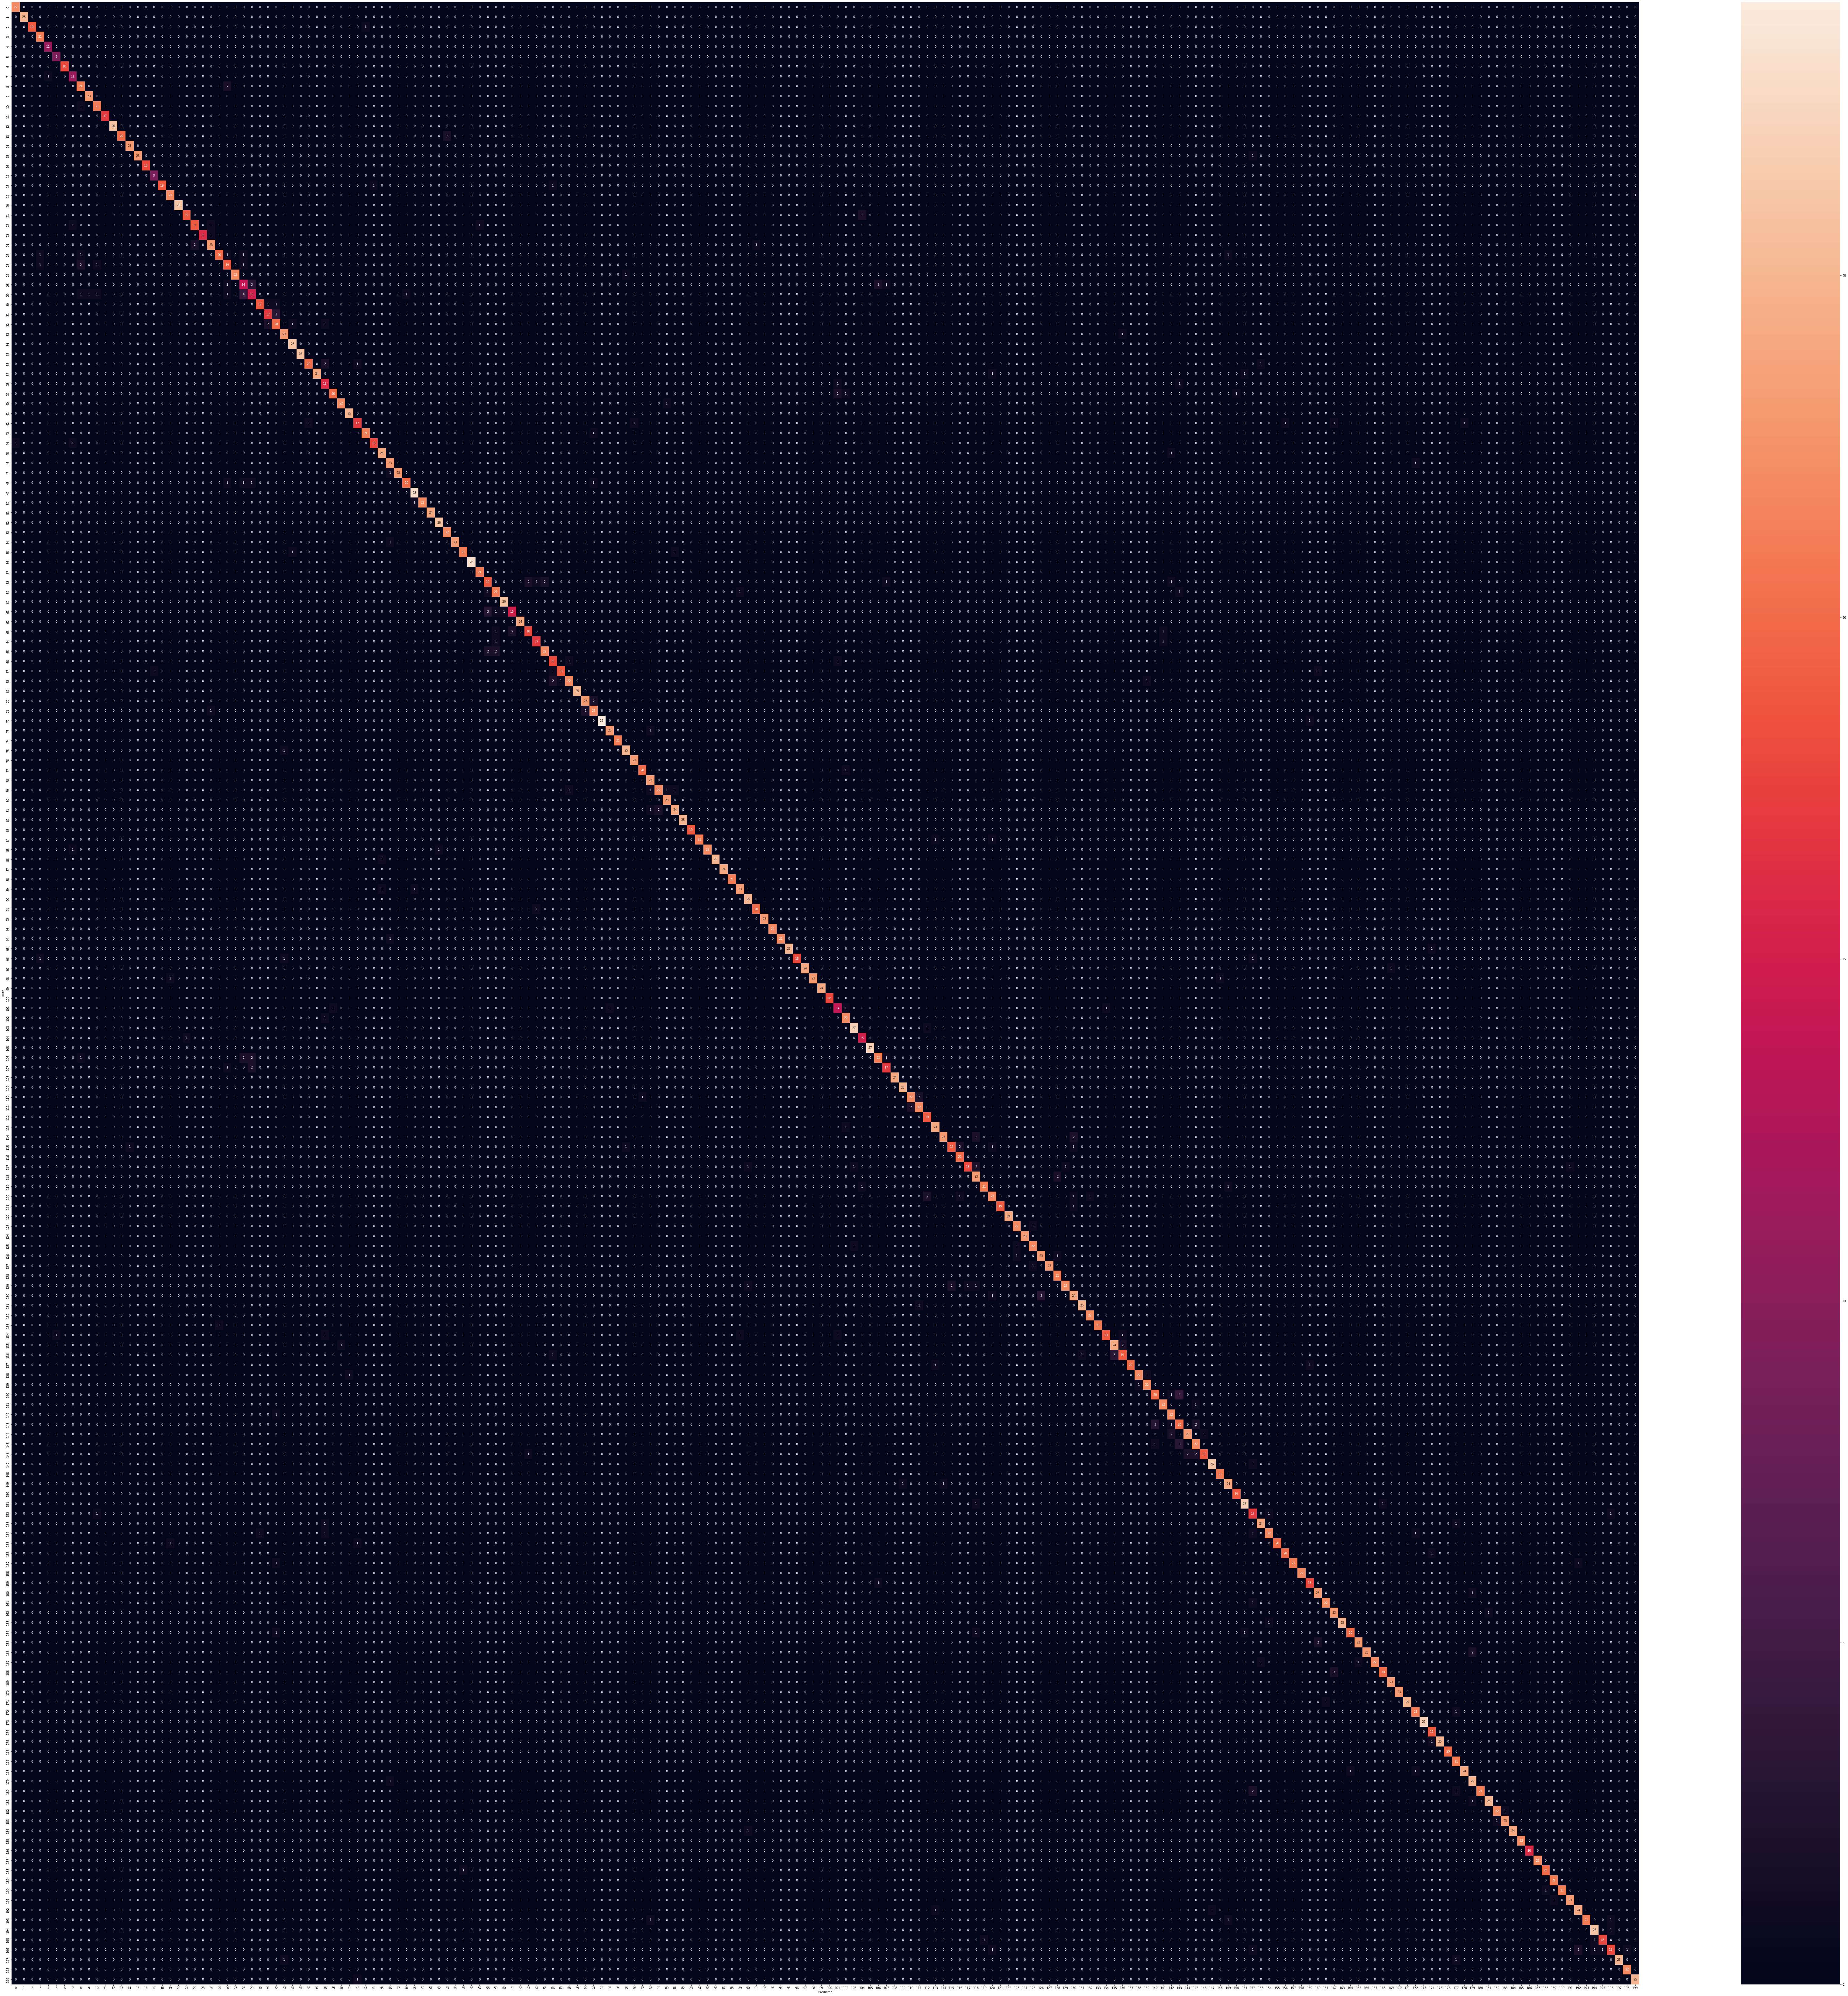

In [14]:
from sklearn.metrics import confusion_matrix

print("Saving confusion matrix...")
# Compute the confusion matrix
cm = confusion_matrix(expected_output_labels, final_predictions)

import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap of the confusion matrix
plt.figure(figsize=(120, 120))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Save the heatmap
plt.savefig("confusion_matrix_heatmap.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


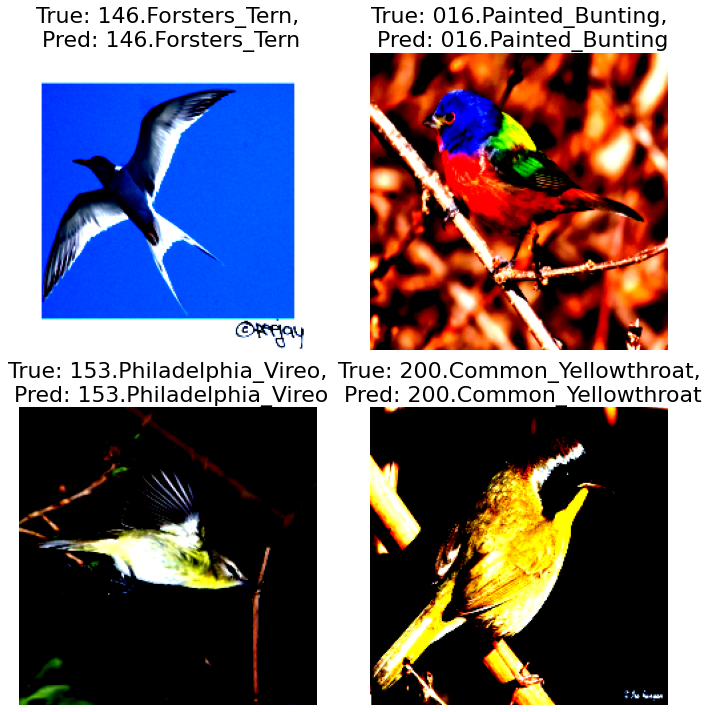

In [25]:
import matplotlib.pyplot as plt

# Get 4 random samples from the test set
samples, labels = next(iter(test_loader))
samples = samples[:4]
labels = labels[:4]

# Move to device
samples = samples.to(device)
labels = labels.to(device)

# Get predictions
model1.eval()
with torch.no_grad():
    model1_preds = model1(samples)
    model2_preds = model2(samples)
    model3_preds = model3(samples)
    model1_preds = model1_preds.cpu()
    model2_preds = model2_preds.cpu()
    model3_preds = model3_preds.cpu()
    
    # Get final prediction of data based on the best weight combination
    final_predictions = [weighted_probability(num_of_classifiers, num_of_classes, [model1_preds[i], model2_preds[i], model3_preds[i]], best_weights) for i in range(0, len(model1_preds))]
    final_predictions = np.array(final_predictions)

    # Get the final classification report
    final_predictions = np.argmax(final_predictions, axis=1)
    expected_output_labels = np.argmax(data_outputs, axis=1)
    outputs = model1(samples)
    _, preds = torch.max(outputs, 1)

# Move samples and labels back to CPU for displaying
samples = samples.cpu()
labels = labels.cpu()
preds = preds.cpu()

# Get the dictionary mapping from label numbers to class names
label_to_name = {i: name for i, name in enumerate(combined_dataset.classes)}

# Plot the images along with their true and predicted labels
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i in range(4):
    row = i // 2
    col = i % 2
    axs[row, col].imshow(np.transpose(samples[i], (1, 2, 0)))  # Un-normalize here if necessary
    axs[row, col].set_title(f'True: {label_to_name[labels[i].item()]},\n Pred: {label_to_name[preds[i].item()]}', fontsize=22)
    axs[row, col].axis('off')
plt.tight_layout()
plt.show()
